<a href="https://colab.research.google.com/github/alonzojp/Magnolia-Beach-Model/blob/main/Functionized_Magnolia_Beach_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import plotly.graph_objects as go
import math
import plotly.express as px
import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

### **Ports Dataframe**

In [2]:
# Combine Port Lavaca & OConnor data together
def generate_ports_df(LAVACA_DATA_PATH, OCONNOR_DATA_PATH):
  lavaca_df = pd.read_csv(LAVACA_DATA_PATH)[:-11]
  oconnor_df = pd.read_csv(OCONNOR_DATA_PATH)[:-11]
  ports_df = pd.concat([lavaca_df, oconnor_df], axis=1)

  ports_df.index = lavaca_df['#date+time']
  ports_df.drop(columns=['#date+time'], inplace=True)
  ports_df.index = pd.to_datetime(ports_df.index, format='%m-%d-%Y %H:%M')

  ports_df[ports_df.columns] = ports_df[ports_df.columns].apply(pd.to_numeric, errors='coerce')

  ports_df = ports_df.drop(columns = ['057-wsd', '057-wdr'])
  ports_df.drop(ports_df['2016-10-30':'2016-11-08'].index, inplace=True) # 033-wsd error

  return ports_df

In [3]:
# Visualization of all data in dataset
def graph_data(df):
  for column in df.columns:
    fig = go.Figure(data=go.Scatter(x=df.index, y=df[column], mode='lines', line_color='#003f5c', name = ""))
    fig.update_traces(connectgaps=False)
    fig.update_layout(title = column, xaxis_title="", yaxis_title="")
    fig.show()

In [4]:
# Converts wsd and wdr to X and Y wind data
def convert_winds(ports_df):
  ports = ['033']
  for port in ports:
    x_wind = []
    y_wind = []
    for i in range(0, len(ports_df)):
      radius = ports_df[port + '-wsd'][i]
      theta = ports_df[port + '-wdr'][i]
      theta = theta * (math.pi / 180)
      x_wind.append(radius * math.cos(theta))
      y_wind.append(radius * math.sin(theta))
    ports_df[port + "-Xwind"] = x_wind
    ports_df[port + "-Ywind"] = y_wind
    del ports_df[port + '-wsd']
    del ports_df[port + '-wdr']
  return ports_df

In [5]:
# Creates estimated Magnolia data
def create_magnolia_data(ports_df):
  ports_df['mag-pwl'] = (ports_df['033-pwl'] + ports_df['057-pwl']) / 2
  ports_df['mag-surge'] = (ports_df['033-surge'] + ports_df['057-surge']) / 2
  ports_df['mag-harmwl'] = (ports_df['033-harmwl'] + ports_df['057-harmwl']) / 2
  return ports_df

In [6]:
LAVACA_DATA_PATH = '/content/Lavaca Data 09_24.csv' #033
OCONNOR_DATA_PATH = '/content/OConnor Data 09_24.csv' #057

ports_df = generate_ports_df(LAVACA_DATA_PATH, OCONNOR_DATA_PATH)
ports_df = create_magnolia_data(ports_df)
ports_df = convert_winds(ports_df)
# graph_data(ports_df)
ports_df

,033-pwl,033-harmwl,033-surge,057-pwl,057-harmwl,057-surge,mag-pwl,mag-surge,mag-harmwl,033-Xwind,033-Ywind
#date+time,,,,,,,,,,,
2010-01-01 00:00:00,0.070,-0.149,0.219,0.153,0.032,0.121,0.1115,0.1700,-0.0585,NaN,NaN
2010-01-01 01:00:00,0.124,-0.083,0.207,0.191,0.073,0.118,0.1575,0.1625,-0.0050,NaN,NaN
2010-01-01 02:00:00,0.182,-0.017,0.199,0.216,0.108,0.108,0.1990,0.1535,0.0455,NaN,NaN
2010-01-01 03:00:00,0.224,0.042,0.182,0.292,0.133,0.159,0.2580,0.1705,0.0875,NaN,NaN
2010-01-01 04:00:00,0.202,0.093,0.109,0.267,0.148,0.119,0.2345,0.1140,0.1205,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,NaN,-0.231,NaN,NaN,-0.207,NaN,NaN,NaN,-0.2190,NaN,NaN
2025-01-01 20:00:00,NaN,-0.272,NaN,NaN,-0.195,NaN,NaN,NaN,-0.2335,NaN,NaN
2025-01-01 21:00:00,NaN,-0.295,NaN,NaN,-0.169,NaN,NaN,NaN,-0.2320,NaN,NaN


### **ANN #1**

In [7]:
# Generates first ANN dataframe
def create_first_ann_df(ports_df, LEAD_TIME):
  ports_df['TARGET'] = ports_df['mag-surge'].shift(-1 * LEAD_TIME + 5) # accounts for 5hr delay
  ports_df['REMOVE (for later conversion)'] = ports_df['mag-harmwl'].shift(-1 * LEAD_TIME + 5) # used later for conversion
  ports_df = ports_df[['033-pwl',	'033-surge',	'033-Xwind',	'033-Ywind', '057-pwl',	'057-surge', 'mag-pwl', 'mag-surge', 'TARGET', 'REMOVE (for later conversion)']]

  organized_df = pd.DataFrame() # adds 'hours back' features
  column_names = ['033-pwl',	'033-surge',	'057-pwl',	'057-surge', 'mag-pwl', 'mag-surge', '033-Xwind',	'033-Ywind']
  for column in column_names:
    for i in range(24, 0, -1):
      df_shifted = ports_df.shift(1 * i)
      organized_df[column + " -" + str(i)] = df_shifted[column]
    organized_df[column] = ports_df[column]

  first_winds_df = pd.DataFrame() # first ANN's wind perfect prog
  for i in range(1, LEAD_TIME + 1 - 5):
    df_reverse_shifted = ports_df.shift(-1 * i)
    first_winds_df['033-Xwind' + " +" + str(i)] = df_reverse_shifted['033-Xwind']
  for i in range(1, LEAD_TIME + 1 - 5):
    df_reverse_shifted = ports_df.shift(-1 * i)
    first_winds_df['033-Ywind' + " +" + str(i)] = df_reverse_shifted['033-Ywind']

  second_winds_df = pd.DataFrame() # second ANN's wind perfect prog
  for i in range(1, LEAD_TIME + 1):
    df_reverse_shifted = ports_df.shift(-1 * i)
    second_winds_df['033-Xwind' + " +" + str(i)] = df_reverse_shifted['033-Xwind']
  for i in range(1, LEAD_TIME + 1):
    df_reverse_shifted = ports_df.shift(-1 * i)
    second_winds_df['033-Ywind' + " +" + str(i)] = df_reverse_shifted['033-Ywind']

  first_df = pd.concat([organized_df, first_winds_df], axis=1) # creating first dataset
  first_df['TARGET'] = ports_df['TARGET']
  first_df['REMOVE (for later conversion)'] = ports_df['REMOVE (for later conversion)']
  first_df = first_df.dropna()
  first_pwl_conversion = first_df['REMOVE (for later conversion)']
  del first_df['REMOVE (for later conversion)']
  return first_df, first_pwl_conversion, second_winds_df

In [8]:
# Generates first ANN data split
def generate_first_ann_split(first_df):
  length = len(first_df)

  train_length = round(length * .6)
  val_length = round(length * .8)

  train_df = first_df[:train_length]
  val_df = first_df[train_length:val_length]
  test_df = first_df[val_length:]

  X_train = train_df.drop('TARGET',axis=1)
  y_train = train_df['TARGET']
  X_val = val_df.drop('TARGET',axis=1)
  y_val = val_df['TARGET']
  X_test = test_df.drop('TARGET',axis=1)
  y_test = test_df['TARGET']

  return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
# Plots train, val, and test distribution
def plot_first_ann(y_train, y_val, y_test):
  fig_train = px.line(y_train)
  fig_train.update_traces(line_color='#EF2648')
  fig_train.update_traces(name='Training')

  fig_val = px.line(y_val)
  fig_val.update_traces(line_color='#FBC800')
  fig_val.update_traces(name='Validation')

  fig_test = px.line(y_test)
  fig_test.update_traces(line_color='#5A8A91')
  fig_test.update_traces(name='Testing')

  fig = go.Figure(data = fig_train.data + fig_val.data + fig_test.data)
  fig.show()

In [10]:
def train_first_ann(X_train, y_train, X_val, y_val, X_test, y_test, units1, activation1):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=20,
                                                  mode='min')

  model = tf.keras.Sequential([
      tf.keras.layers.Dense(units1,
                            activation= activation1,
                            input_shape = [X_train.shape[1]],
                            kernel_regularizer = tf.keras.regularizers.L2(l2=0.0001)
                            ),
      tf.keras.layers.Dense(1),
  ])

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  losses = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    epochs=1000, batch_size = 32,
                    shuffle=True)

  return model, losses

In [11]:
CHANGING_TIME = 24

first_df, first_pwl_conversion, second_winds_df = create_first_ann_df(ports_df, CHANGING_TIME)
X_train, y_train, X_val, y_val, X_test, y_test = generate_first_ann_split(first_df)
plot_first_ann(y_train, y_val, y_test)

model, losses = train_first_ann(X_train, y_train, X_val, y_val, X_test, y_test, 128, 'relu')

Epoch 1/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.4770 - mean_absolute_error: 0.4267 - val_loss: 0.0586 - val_mean_absolute_error: 0.1561
Epoch 2/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0457 - mean_absolute_error: 0.1353 - val_loss: 0.0319 - val_mean_absolute_error: 0.1115
Epoch 3/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0247 - mean_absolute_error: 0.0906 - val_loss: 0.0192 - val_mean_absolute_error: 0.0758
Epoch 4/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0165 - mean_absolute_error: 0.0724 - val_loss: 0.0198 - val_mean_absolute_error: 0.0905
Epoch 5/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0123 - mean_absolute_error: 0.0635 - val_loss: 0.0127 - val_mean_absolute_error: 0.0712
Epoch 6/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0095 - mean_absolute_error: 0.0574 - val_loss: 0.0107 - val_mean_absolute_error: 0.0628
Epoch 7/1000
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0081 - me

<Axes: >

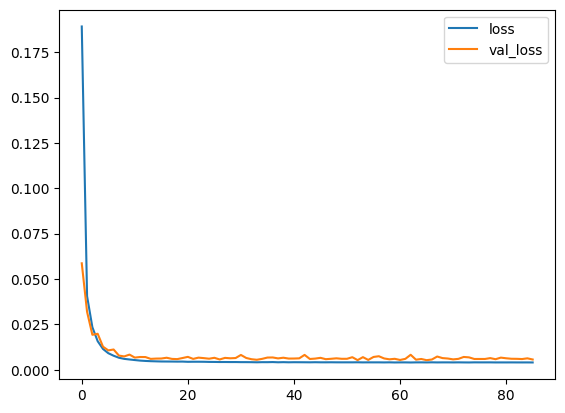

In [13]:
loss_df = pd.DataFrame(losses.history)
loss_df.loc[:,['loss','val_loss']].plot()